In [1]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter

In [2]:
# import sys
# sys.path.append("../")

# %load_ext autoreload
# %autoreload 2

### Prepare data

In [3]:
dataset_path = "../data/chest_xray"

In [4]:
dataset = torchvision.datasets.ImageFolder(root=dataset_path, 
                                 transform = None,
                                 target_transform = None,
                                 )

In [5]:
len(dataset)

5856

In [6]:
Counter(dataset.targets)

Counter({0: 1583, 1: 4273})

In [7]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

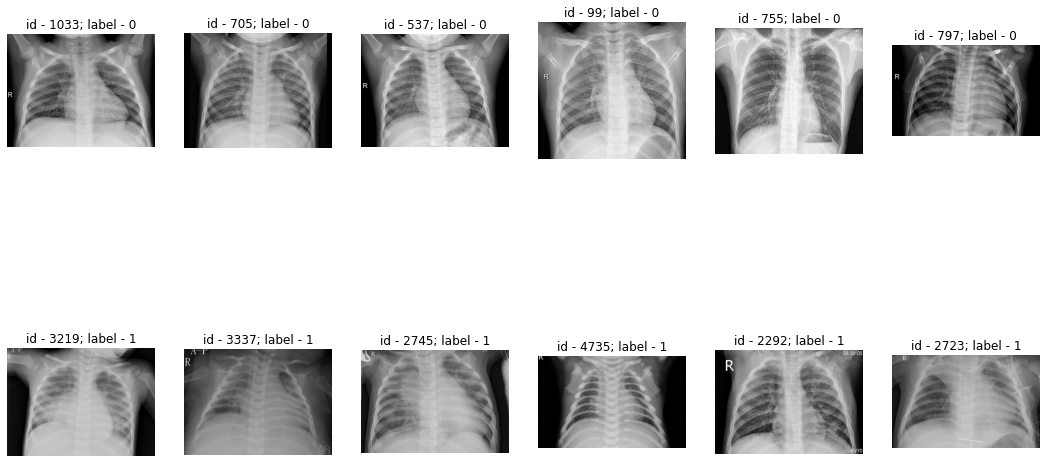

In [8]:
visualize_classes(dataset)

In [9]:
dataset = torchvision.datasets.ImageFolder(
    root=dataset_path, 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [10]:
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

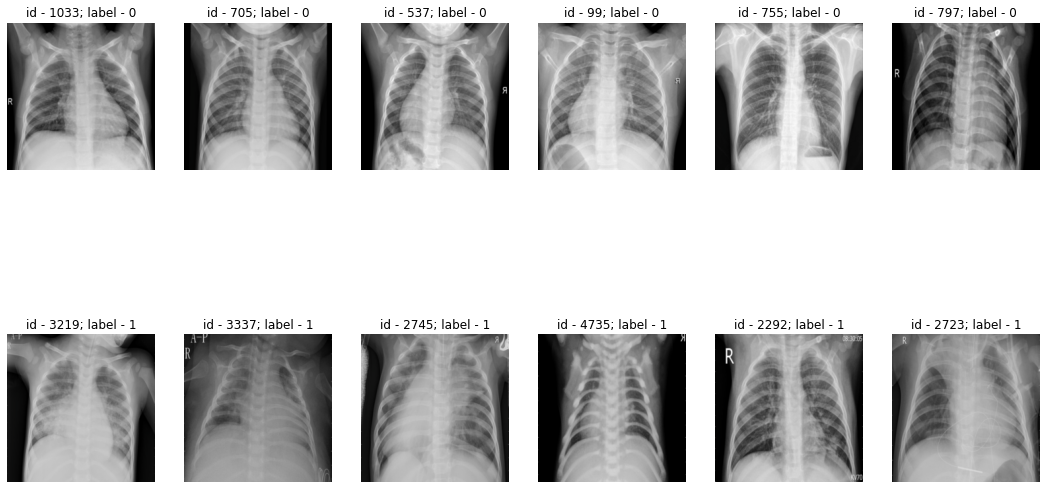

In [11]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [12]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=True, num_workers=2
)

In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

### Train model

In [15]:
def epoch(loader, model, device, criterion, opt=None):
    probabilities = []
    all_labels = []
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * inputs.size(0)
        all_labels.extend(list(labels.cpu().detach().numpy().reshape(-1)))
        probabilities.extend(list(outputs.cpu().detach().numpy()[:, 1].reshape(-1)))
    return total_loss / float(len(loader.dataset)), all_labels, probabilities

In [16]:
def print_metrics(writer, phase, epoch_num, loss, labels, prob, lr=None):
    acc = accuracy_score(labels, (np.array(prob) > 0.5).astype(int))
    ap = average_precision_score(labels, prob)

    writer.add_scalar(f'Loss', loss, epoch_num)
    writer.add_scalar(f'Accuracy', acc, epoch_num)
    writer.add_scalar(f'Average precision', ap, epoch_num)
    if lr is not None:
        writer.add_scalar(f'LR', lr, epoch_num)
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f} LR: {lr}")
    else:
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f}")

In [17]:
def create_writers(log_dir: str = "./runs"):
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    train_log_dir = f"{log_dir}/{current_time}/train/"
    val_log_dir = f"{log_dir}/{current_time}/val/"
    train_writer = SummaryWriter(log_dir=train_log_dir)
    val_writer = SummaryWriter(log_dir=val_log_dir)
    return train_writer, val_writer

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    best_epoch = 0
    train_writer, val_writer = create_writers("../runs")
    model.train()

    for epoch_num in range(num_epochs):
        print(f"Epoch {epoch_num}/{num_epochs - 1}")
        print("-" * 10)

        train_loss, train_labels, train_prob = epoch(train_loader, model, device, criterion, opt = optimizer)
        val_loss, val_labels, val_prob = epoch(test_loader, model, device, criterion)

        print_metrics(train_writer, "train", epoch_num, train_loss, train_labels, train_prob, optimizer.param_groups[0]["lr"])
        print_metrics(val_writer, "val", epoch_num, val_loss, val_labels, val_prob)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch_num
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val loss: {best_loss:4f} Best epoch: {best_epoch}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
device = "cuda:0"
# device = "cpu"

In [20]:
model_ft = models.vgg11_bn(pretrained=True)

model_ft.classifier[6] = nn.Sequential(
    nn.Linear(4096, 2),
    nn.Softmax(),
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', patience=5, eps=1e-07)

In [21]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.5847 Acc: 0.7274 AP: 0.7201 LR: 0.001
val Loss: 0.5756 Acc: 0.7381 AP: 0.7362

Epoch 1/14
----------
train Loss: 0.5852 Acc: 0.7252 AP: 0.7282 LR: 0.001
val Loss: 0.5718 Acc: 0.7381 AP: 0.8158

Epoch 2/14
----------
train Loss: 0.5855 Acc: 0.7280 AP: 0.6569 LR: 0.001
val Loss: 0.5732 Acc: 0.7381 AP: 0.7270

Epoch 3/14
----------
train Loss: 0.5825 Acc: 0.7308 AP: 0.6648 LR: 0.001
val Loss: 0.5753 Acc: 0.7381 AP: 0.6072

Epoch 4/14
----------
train Loss: 0.5772 Acc: 0.7340 AP: 0.7121 LR: 0.001
val Loss: 0.5289 Acc: 0.7833 AP: 0.9411

Epoch 5/14
----------
train Loss: 0.5894 Acc: 0.7237 AP: 0.7301 LR: 0.001
val Loss: 0.5752 Acc: 0.7381 AP: 0.7239

Epoch 6/14
----------
train Loss: 0.5737 Acc: 0.7376 AP: 0.7455 LR: 0.001
val Loss: 0.5752 Acc: 0.7381 AP: 0.7381

Epoch 7/14
----------
train Loss: 0.5857 Acc: 0.7276 AP: 0.7189 LR: 0.001
val Loss: 0.5752 Acc: 0.7381 AP: 0.7214

Epoch 8/14
----------
train Loss: 0.5525 Acc: 0.7573 AP: 0.7769 LR: 0.001
val Lo

### Analyze results

In [22]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model_ft.eval()
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model_ft(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 74/74 [00:06<00:00, 11.98it/s]


In [23]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [24]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [25]:
df["error_type"] = df.apply(error_class, axis=1)

In [26]:
df.groupby("error_type").count()

,true,pred,prob
error_type,,,
FN,79,79,79
FP,48,48,48
TN,259,259,259
TP,786,786,786


In [27]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.8916382252559727
average_precision_score - 0.9237790796777244


In [28]:
n = 10
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [29]:
df

,true,pred,prob,error_type
0,0,0,2.494421e-01,TN
1,1,1,1.000000e+00,TP
2,1,1,1.000000e+00,TP
3,0,0,9.498346e-15,TN
4,1,1,1.000000e+00,TP
...,...,...,...,...
1167,1,1,1.000000e+00,TP
1168,0,0,2.288320e-42,TN
1169,1,0,1.813828e-03,FN
1170,1,1,1.000000e+00,TP


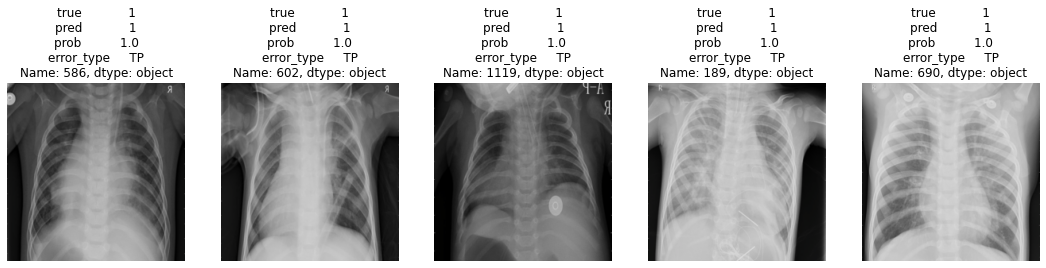

In [30]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

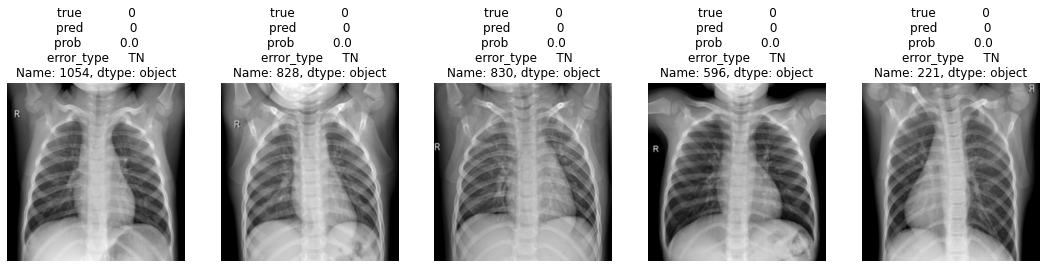

In [31]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

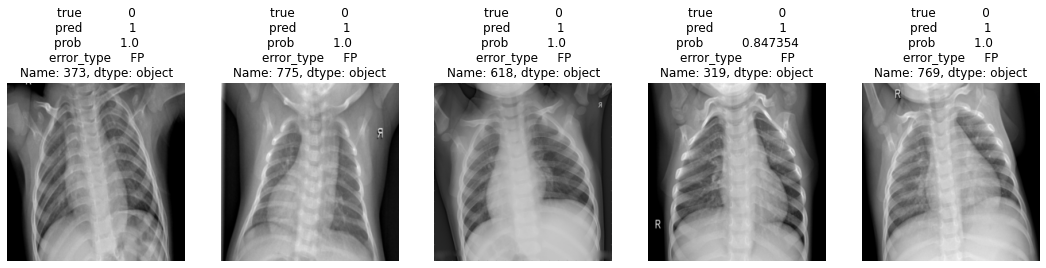

In [32]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

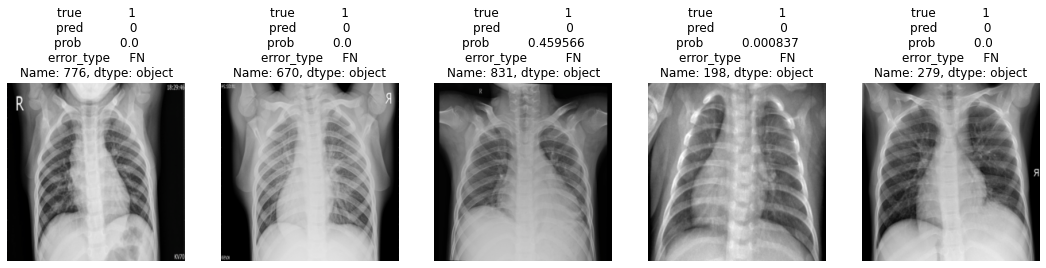

In [33]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Save model

In [35]:
save_path = f"../models/5.3_vgg11_bn_{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}.pt"
torch.save(model_ft.state_dict(), save_path)
save_path

'../models/5.3_vgg11_bn_2021-04-13_02:58:10.pt'

In [36]:
model = models.vgg11_bn()
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke